# Bayesian Linear Regression Construction with Pyro

One of the most beneficial uses for probabilistic programming is the construction of probabilistic machine learning models.

Generally speaking, machine learning models are designed as functions, or mappings, from an input to an output. We have some input $X$ which is an $m\times n$ matrix of $m$ data points with $n$ features each, and we want to construct some mapping $f$ which transforms the features into predictions of some unknown values $\vec{y} = \mathbb{R}^n$

in essence, we're interested in a function:

$$f(X) = y$$

and we'd like our ML models to approximate it as best as possible, ideally while also giving us an idea for **why** the produced certain predictions.

One of the basic ML models which accomplishes both is the linear regression which simply maps $y$ as a linear response of $X$ given some coefficients, $\beta$, such that

$$ y = \beta X$$

However, one major drawback of simple linear regressions is that they create point estimates of $\beta$ without taking uncertainty into account. In this article we'll discuss how to leverage PyTorch and Pyro to produce linear regression models which create uncertainty estimates both for the parameters, as well as for predictions.

## Employing Scikit-learn's Linear Regression

We'll start by exploring a simple linear regression from `sklearn`, and see how it behaves on one of the built in datasets in `sklearn`, the California Housing dataset.

We'll start by importing all our required libraries

In [1]:
import numpy as np
np.set_printoptions(suppress=True)

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Now let's import the housing dataset, and explore its features

In [2]:
from sklearn.datasets import fetch_california_housing

california = fetch_california_housing()

X = california.data
y = california.target

print(f'Data shape is {X.shape}')
print(f'Target shape is {y.shape}')

Data shape is (20640, 8)
Target shape is (20640,)


In [3]:
print(california.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

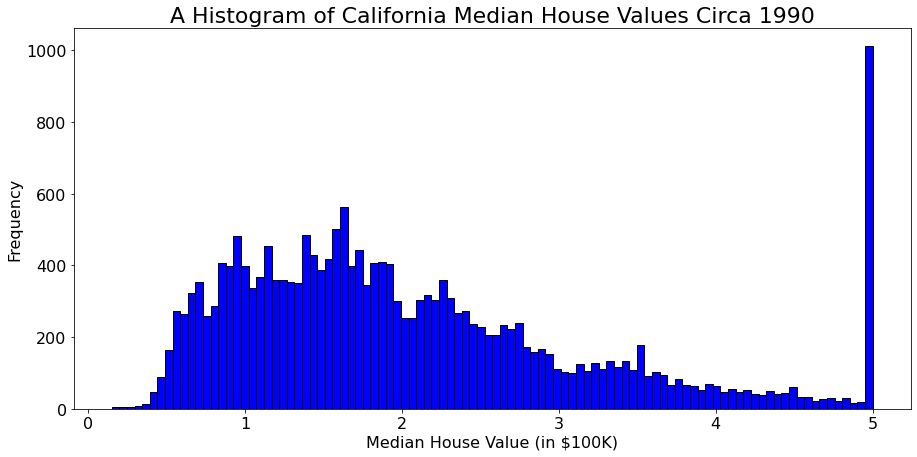

In [4]:
plt.figure(figsize=(15,7))
plt.hist(y, bins=100, color="blue", edgecolor="black")
plt.xlabel("Median House Value (in $100K)", size=16)
plt.ylabel("Frequency", size=16)
plt.title("A Histogram of California Median House Values Circa 1990", size=22)
plt.xticks(size=16)
plt.yticks(size=16)
plt.savefig("HouseValues.png", dpi=36*4)
plt.show()



There are two important observations to be made from this data; First, the distribution of prices is not normal, it is closer to a Gamma distribution. Second, there is a very sharp spike of instances at the \\$500,000 mark, this can an indication of "censored" data. In essence, the data might have been recorded up to \\$500,000, at which point it was recorded as "\\$500,000+"

Let's explore how well a linear regression performs on this data:

In [5]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

my_linear_regression = LinearRegression().fit(X,y)

print(my_linear_regression.intercept_)
print(my_linear_regression.coef_)

y_pred = my_linear_regression.predict(X)

y_small = y[y<5.0]
y_pred_small = y_pred[y<5.0]

y_pred = np.where(y_pred > 5.0, 5.0, y_pred)

-36.941920207184324
[ 0.43669329  0.00943578 -0.10732204  0.64506569 -0.00000398 -0.00378654
 -0.42131438 -0.43451375]


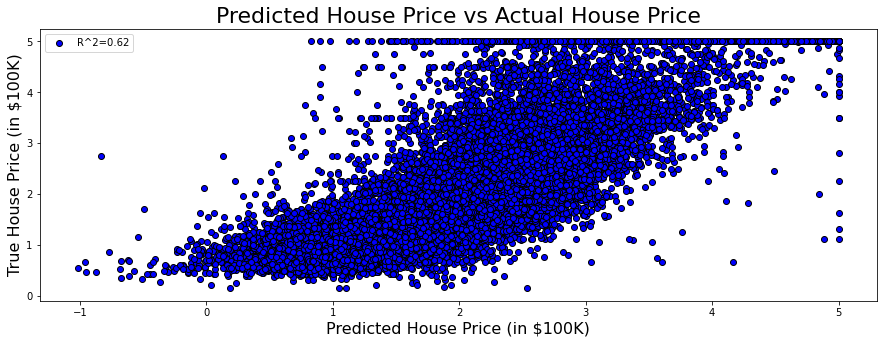

In [6]:
plt.figure(figsize=(15, 5))
plt.scatter(y_pred, y, c="blue", edgecolor="black", label=f'R^2={round(r2_score(y, y_pred),2)}')
plt.title("Predicted House Price vs Actual House Price", size=22)
plt.xlabel("Predicted House Price (in $100K)", size=16)
plt.ylabel("True House Price (in $100K)", size=16)
plt.legend()
plt.show()

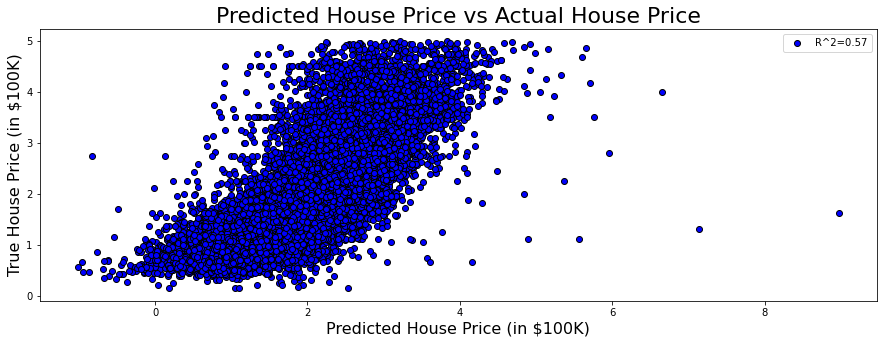

In [7]:
plt.figure(figsize=(15, 5))
plt.scatter(y_pred_small, y_small, c="blue", edgecolor="black", label=f'R^2={round(r2_score(y_small, y_pred_small),2)}')
plt.title("Predicted House Price vs Actual House Price", size=22)
plt.xlabel("Predicted House Price (in $100K)", size=16)
plt.ylabel("True House Price (in $100K)", size=16)
plt.legend()
plt.show()

There are a few issues with this model

In [8]:
import torch
import pyro
import pyro.distributions as dist

from pyro.infer import MCMC, NUTS

torch.manual_seed(0)
pyro.set_rng_seed(0)

import time

In [9]:
def model_normal(X, y, column_names):
    
    
    linear_combination = pyro.sample(f"beta_intercept", dist.Normal(0.0, 1.0))
    
    
    for i in range(0, X.shape[1]):
        beta_i = pyro.sample(f"beta_{column_names[i]}", dist.Normal(0.0, 1.0))
        linear_combination = linear_combination + (beta_i * X[:, i])
    
    sigma = pyro.sample("sigma", dist.HalfCauchy(scale=10.0))
    

    mean = linear_combination
    
    
    with pyro.plate("data", y.shape[0]):
        
        outcome_dist = dist.Normal(mean, sigma)
        
        observation = pyro.sample("obs", outcome_dist, obs=y)

In [10]:
pyro.clear_param_store()
my_kernel = NUTS(model_normal, max_tree_depth=7)


my_mcmc1 = MCMC(my_kernel,
                num_samples=6000,
                warmup_steps=100)

X_torch = torch.tensor(X)
y_torch = torch.tensor(y)


start_time = time.time()
my_mcmc1.run(X_torch,y_torch, california.feature_names)
end_time = time.time()

print(f'Inference ran for {round(end_time -  start_time, 2)} seconds')

Sample: 100%|██████████| 6100/6100 [10:00, 10.16it/s, step size=9.70e-04, acc. prob=0.237]

Inference ran for 600.14 seconds


In [11]:
my_mcmc1.summary()


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta_intercept      0.10      0.00      0.10      0.10      0.10     17.14      1.03
      beta_MedInc     -0.49      0.16     -0.43     -0.71     -0.43      8.44      1.15
    beta_HouseAge     -0.03      0.02     -0.02     -0.05     -0.02     13.95      1.09
    beta_AveRooms     -0.50      0.39     -0.37     -0.99     -0.35      8.64      1.14
   beta_AveBedrms     -1.36      0.02     -1.36     -1.40     -1.35      8.63      1.15
  beta_Population     -0.00      0.00     -0.00     -0.00     -0.00     10.78      1.11
    beta_AveOccup      0.04      0.17      0.00     -0.00      0.01     20.62      1.05
    beta_Latitude     -0.14      0.20     -0.19     -0.20     -0.17     15.19      1.08
   beta_Longitude     -0.12      0.04     -0.12     -0.16     -0.12     23.12      1.03
            sigma      3.01      1.78      2.47      2.44      4.12     11.53      1.10

Number of divergences: 4600


In [12]:
def create_beta_df(my_mcmc, scaler=None):
    beta_df = pd.DataFrame(my_mcmc.get_samples())


    if (scaler is not None):
        i = 0
        for col in beta_df:
            if (col != 'beta_intercept'):
                if ('beta_' in col):

                    beta_df['beta_intercept'] -= (beta_df[col] * scaler.mean_[i])/scaler.scale_[i]
                    beta_df[col] /= scaler.scale_[i]

                    i += 1

    return beta_df

In [13]:
def draw_coefficients(beta_df):
    figure, axis = plt.subplots(5,2, figsize=(15,15))


    for key, ax in zip(beta_df.columns, axis.ravel()):
        ax.set_title(key)
        ax.hist(beta_df[key], color="blue", edgecolor="black", bins=100)

    plt.subplots_adjust(hspace=0.5)

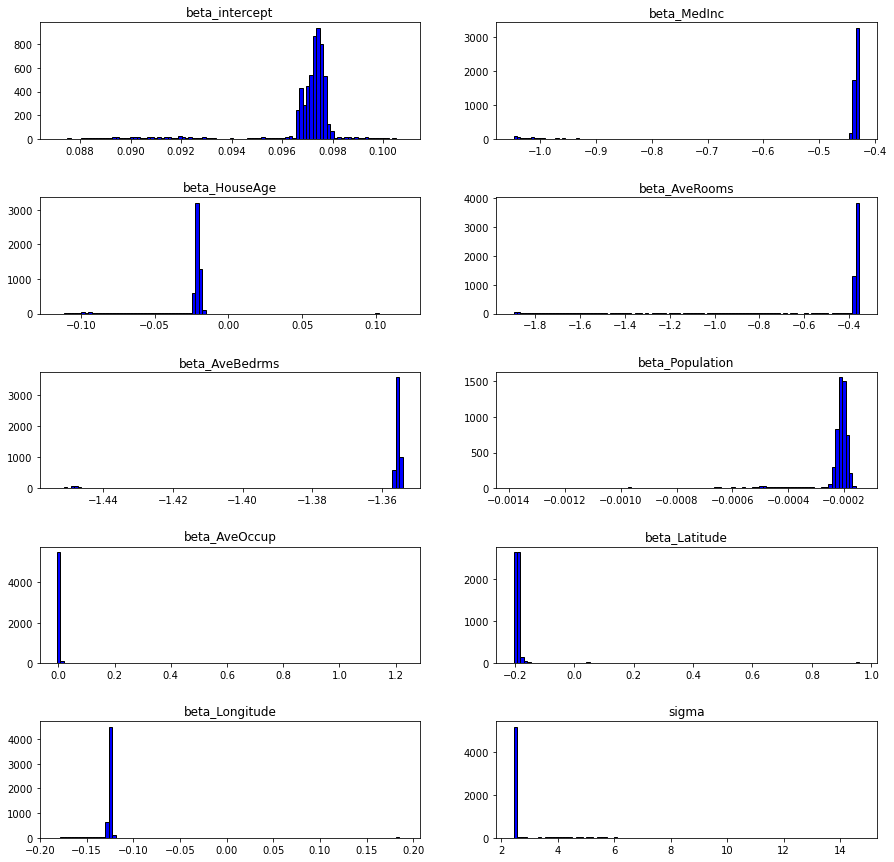

In [14]:
beta_df = create_beta_df(my_mcmc1)
draw_coefficients(beta_df)

In [15]:
coefficients = beta_df.iloc[:, :-1].mean()
coefficients

linear_combination = X.dot(coefficients[1:]) + coefficients.iloc[0]
linear_combination.shape

(20640,)

In [16]:
y_pred = linear_combination
y_pred_small = y_pred[y<5.0]
y_pred= np.where(y_pred > 5.0, 5.0, y_pred)

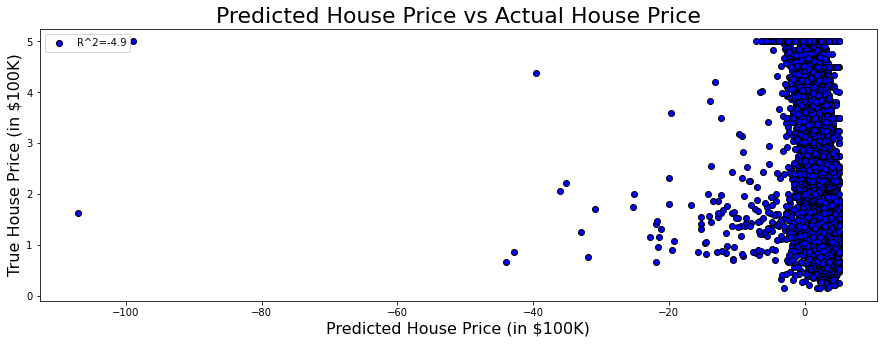

In [17]:
plt.figure(figsize=(15, 5))
plt.scatter(y_pred, y, c="blue", edgecolor="black", label=f'R^2={round(r2_score(y, y_pred), 2)}')
plt.title("Predicted House Price vs Actual House Price", size=22)
plt.xlabel("Predicted House Price (in $100K)", size=16)
plt.ylabel("True House Price (in $100K)", size=16)
plt.legend()
plt.show()

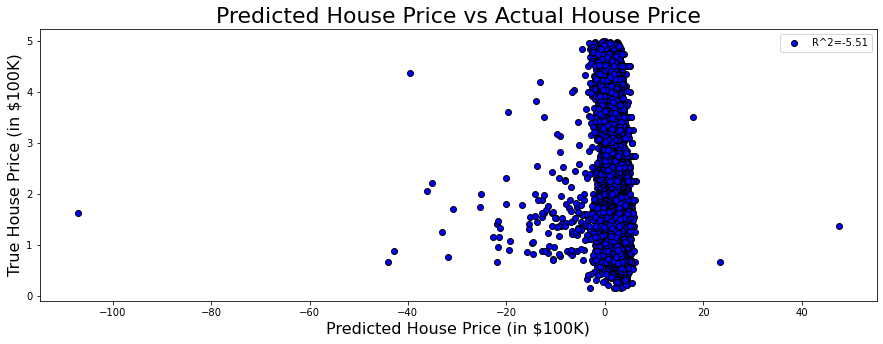

In [18]:
plt.figure(figsize=(15, 5))
plt.scatter(y_pred_small, y_small, c="blue", edgecolor="black", label=f'R^2={round(r2_score(y_small, y_pred_small),2)}')
plt.title("Predicted House Price vs Actual House Price", size=22)
plt.xlabel("Predicted House Price (in $100K)", size=16)
plt.ylabel("True House Price (in $100K)", size=16)
plt.legend()
plt.show()

## Scaled data

In [19]:
from sklearn.preprocessing import StandardScaler

my_scaler = StandardScaler()
X_scaled = my_scaler.fit_transform(X)

pyro.clear_param_store()
my_kernel = NUTS(model_normal, max_tree_depth=7)


my_mcmc2 = MCMC(my_kernel,
                num_samples=6000,
                warmup_steps=100)

X_torch = torch.tensor(X_scaled)
y_torch = torch.tensor(y)


start_time = time.time()
my_mcmc2.run(X_torch,y_torch, california.feature_names)
end_time = time.time()

print(f'Inference ran for {round(end_time -  start_time, 2)} seconds')
my_mcmc2.summary()

Sample: 100%|██████████| 6100/6100 [27:15,  3.73it/s, step size=1.89e-02, acc. prob=0.961]


Inference ran for 1635.66 seconds

                       mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta_intercept      2.07      0.01      2.07      2.06      2.08   2408.38      1.00
      beta_MedInc      0.83      0.01      0.83      0.82      0.84   6563.72      1.00
    beta_HouseAge      0.12      0.01      0.12      0.11      0.13   5396.65      1.00
    beta_AveRooms     -0.27      0.01     -0.27     -0.29     -0.24   6430.53      1.00
   beta_AveBedrms      0.31      0.01      0.31      0.28      0.33   6442.70      1.00
  beta_Population     -0.00      0.01     -0.00     -0.01      0.00   3270.81      1.00
    beta_AveOccup     -0.04      0.01     -0.04     -0.05     -0.03   2578.10      1.00
    beta_Latitude     -0.90      0.02     -0.90     -0.93     -0.88   6479.63      1.00
   beta_Longitude     -0.87      0.02     -0.87     -0.89     -0.84   6300.33      1.00
            sigma      0.72      0.00      0.72      0.72      0.73   8633.48      1.

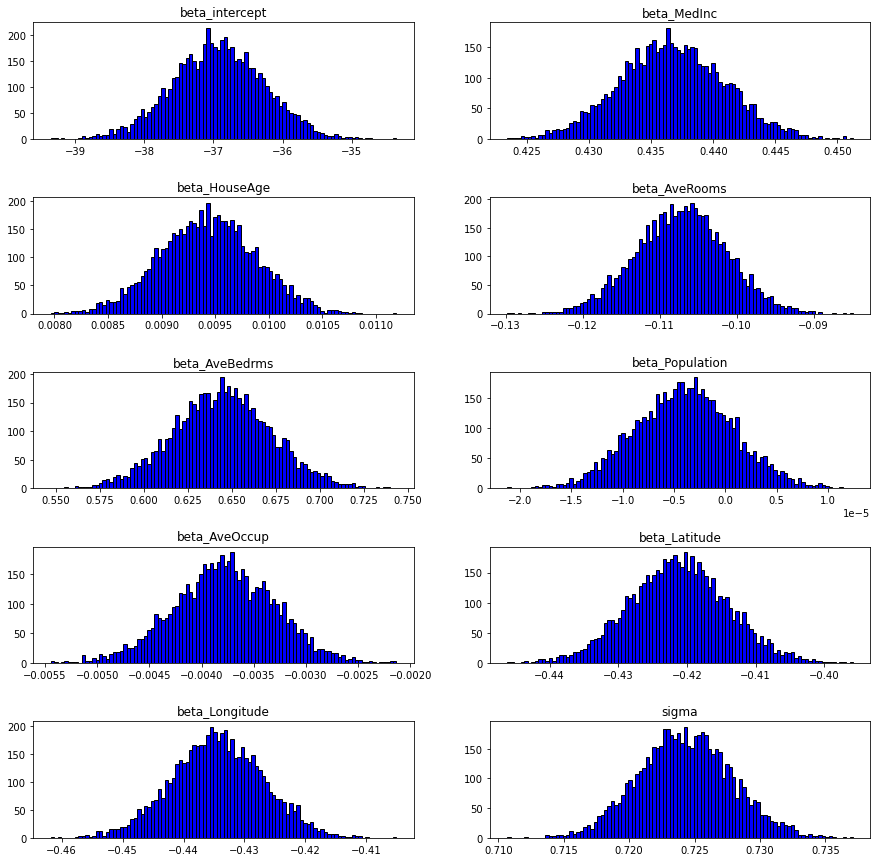

In [20]:
beta2_df = create_beta_df(my_mcmc2, my_scaler)
draw_coefficients(beta2_df)

In [21]:
coefficients = beta2_df.iloc[:, :-1].median()
coefficients

linear_combination = X.dot(coefficients[1:]) + coefficients.iloc[0]
linear_combination.shape

(20640,)

In [22]:
y_pred = linear_combination
y_pred_small = y_pred[y<5.0]
y_pred= np.where(y_pred > 5.0, 5.0, y_pred)

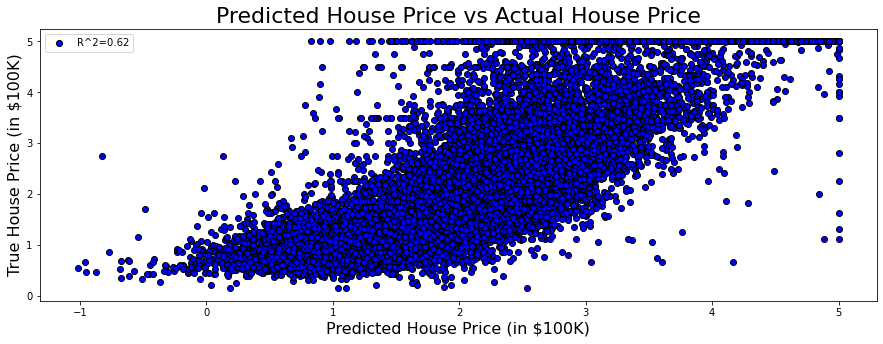

In [23]:
plt.figure(figsize=(15, 5))
plt.scatter(y_pred, y, c="blue", edgecolor="black", label=f'R^2={round(r2_score(y, y_pred), 2)}')
plt.title("Predicted House Price vs Actual House Price", size=22)
plt.xlabel("Predicted House Price (in $100K)", size=16)
plt.ylabel("True House Price (in $100K)", size=16)
plt.legend()
plt.show()

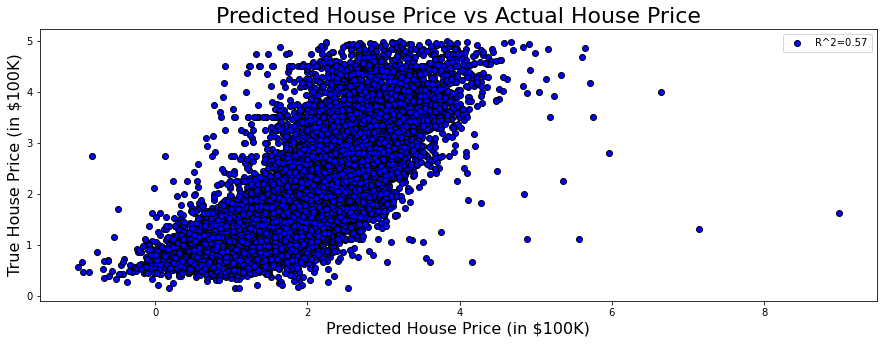

In [24]:
plt.figure(figsize=(15, 5))
plt.scatter(y_pred_small, y_small, c="blue", edgecolor="black", label=f'R^2={round(r2_score(y_small, y_pred_small),2)}')
plt.title("Predicted House Price vs Actual House Price", size=22)
plt.xlabel("Predicted House Price (in $100K)", size=16)
plt.ylabel("True House Price (in $100K)", size=16)
plt.legend()
plt.show()

## Gamma Distribution

In [25]:
def model_gamma(X, y, column_names):
    
    
    linear_combination = pyro.sample(f"beta_intercept", dist.Normal(0.0, 1.0))
    
    
    for i in range(0, X.shape[1]):
        beta_i = pyro.sample(f"beta_{column_names[i]}", dist.Normal(0.0, 1.0))
        linear_combination = linear_combination + (beta_i * X[:, i])
    
    rate = pyro.sample("rate", dist.HalfCauchy(scale=10.0))
    

    mean = torch.exp(linear_combination)
    
    shape = mean * rate
    
    
    
    
    with pyro.plate("data", y.shape[0]):
        
        outcome_dist = dist.Gamma(shape, rate)
        
        observation = pyro.sample("obs", outcome_dist, obs=y)

In [26]:
from sklearn.preprocessing import StandardScaler

my_scaler = StandardScaler()
X_scaled = my_scaler.fit_transform(X)

pyro.clear_param_store()
my_kernel = NUTS(model_gamma, max_tree_depth=7)


my_mcmc3 = MCMC(my_kernel,
                num_samples=6000,
                warmup_steps=100)

X_torch = torch.tensor(X_scaled)
y_torch = torch.tensor(y)


start_time = time.time()
my_mcmc3.run(X_torch,y_torch, california.feature_names)
end_time = time.time()

print(f'Inference ran for {round(end_time -  start_time, 2)} seconds')
my_mcmc3.summary()

Sample: 100%|██████████| 6100/6100 [21:19,  4.77it/s, step size=1.29e-02, acc. prob=0.926]


Inference ran for 1279.63 seconds

                       mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta_intercept      0.62      0.00      0.62      0.62      0.63   5949.69      1.00
      beta_MedInc      0.24      0.00      0.24      0.24      0.24   2271.45      1.00
    beta_HouseAge      0.04      0.00      0.04      0.03      0.04   2142.09      1.00
    beta_AveRooms      0.02      0.01      0.02      0.01      0.03   1936.88      1.00
   beta_AveBedrms      0.00      0.01      0.00     -0.00      0.01   1904.45      1.00
  beta_Population      0.03      0.00      0.03      0.03      0.03   1969.32      1.00
    beta_AveOccup     -1.50      0.04     -1.50     -1.56     -1.44   5823.90      1.00
    beta_Latitude     -0.65      0.01     -0.65     -0.66     -0.64   5310.38      1.00
   beta_Longitude     -0.58      0.01     -0.58     -0.60     -0.57   5770.30      1.00
             rate      4.65      0.05      4.65      4.57      4.73   9006.66      1.

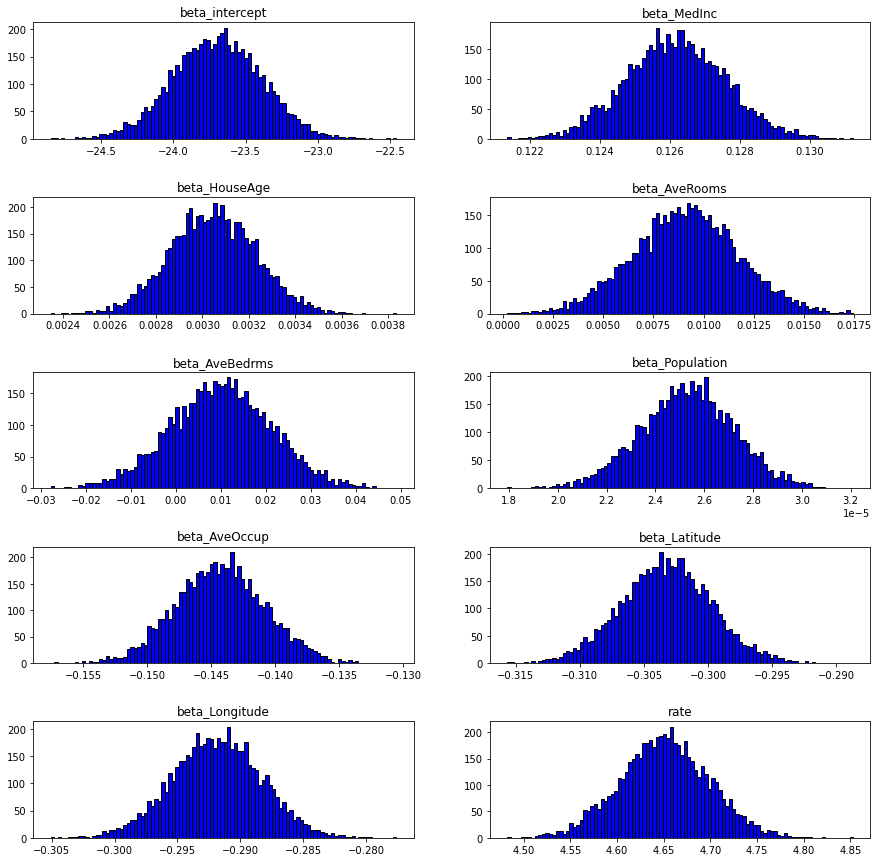

In [27]:
beta3_df = create_beta_df(my_mcmc3, my_scaler)
draw_coefficients(beta3_df)

In [28]:
coefficients = beta3_df.iloc[:, :-1].median()
coefficients

linear_combination = X.dot(coefficients[1:]) + coefficients.iloc[0]
linear_combination.shape

(20640,)

In [29]:
y_pred = np.exp(linear_combination)
y_pred_small = y_pred[y<5.0]
y_pred= np.where(y_pred > 5.0, 5.0, y_pred)

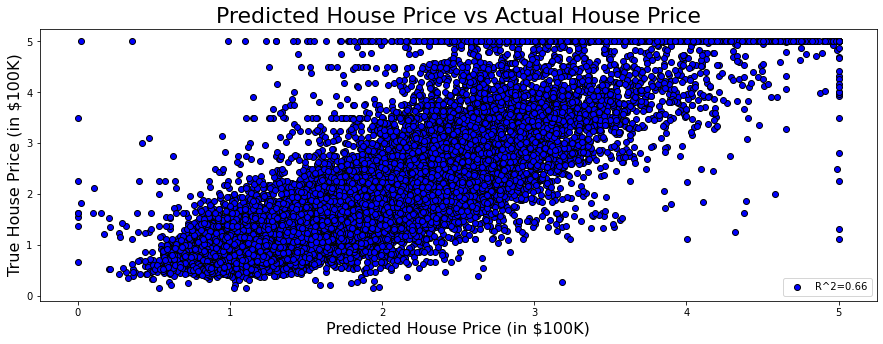

In [30]:
plt.figure(figsize=(15, 5))
plt.scatter(y_pred, y, c="blue", edgecolor="black", label=f'R^2={round(r2_score(y, y_pred), 2)}')
plt.title("Predicted House Price vs Actual House Price", size=22)
plt.xlabel("Predicted House Price (in $100K)", size=16)
plt.ylabel("True House Price (in $100K)", size=16)
plt.legend()
plt.show()

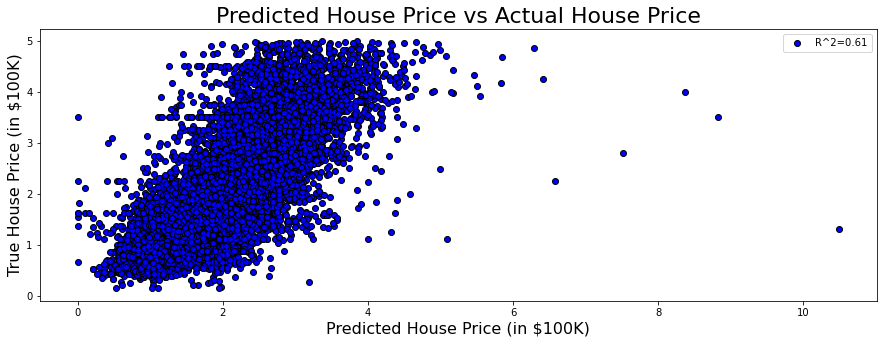

In [31]:
plt.figure(figsize=(15, 5))
plt.scatter(y_pred_small, y_small, c="blue", edgecolor="black", label=f'R^2={round(r2_score(y_small, y_pred_small),2)}')
plt.title("Predicted House Price vs Actual House Price", size=22)
plt.xlabel("Predicted House Price (in $100K)", size=16)
plt.ylabel("True House Price (in $100K)", size=16)
plt.legend()
plt.show()

## Gamma + Censored data

In [32]:
from scipy.stats import gamma as scipygamma
def model_gamma_cen(X, y, column_names, censored_label):
    
    
    linear_combination = pyro.sample(f"beta_intercept", dist.Normal(0.0, 1.0))
    
    
    for i in range(0, X.shape[1]):
        beta_i = pyro.sample(f"beta_{column_names[i]}", dist.Normal(0.0, 1.0))
        linear_combination = linear_combination + (beta_i * X[:, i])
    
    rate = pyro.sample("rate", dist.HalfCauchy(scale=10.0))
    

    mean = torch.exp(linear_combination)
    
    shape = mean * rate
    
    
    
    
    with pyro.plate("data", y.shape[0]):
        
        outcome_dist = dist.Gamma(shape, rate)
        
        with pyro.poutine.mask(mask = (censored_label == 0.0)):
            observation = pyro.sample("obs", outcome_dist, obs=y)
            
        with pyro.poutine.mask(mask = (censored_label == 1.0)):

            truncation_prob = torch.tensor(1 - scipygamma(shape.detach(), rate.detach()).cdf(y))
            
            censored_observation = pyro.sample("censorship",
                                               dist.Bernoulli(truncation_prob),
                                               obs=torch.tensor(1.0))
        

In [33]:
from sklearn.preprocessing import StandardScaler

my_scaler = StandardScaler()
X_scaled = my_scaler.fit_transform(X)

pyro.clear_param_store()
my_kernel = NUTS(model_gamma_cen, max_tree_depth=7)


my_mcmc4 = MCMC(my_kernel,
                num_samples=6000,
                warmup_steps=100)

X_torch = torch.tensor(X_scaled)
y_torch = torch.tensor(y)

numpy_censored_label = np.where(y >= 5.0, 1.0, 0.0)
censored_label = torch.tensor(numpy_censored_label)


start_time = time.time()
my_mcmc4.run(X_torch,y_torch, california.feature_names, censored_label)
end_time = time.time()

print(f'Inference ran for {round(end_time -  start_time, 2)} seconds')
my_mcmc4.summary()

Warmup:   0%|          | 0/6100 [00:00, ?it/s]/anaconda3/envs/pyroenv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:873: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))
Sample: 100%|██████████| 6100/6100 [40:41,  2.50it/s, step size=1.55e-03, acc. prob=0.941]


Inference ran for 2441.87 seconds

                       mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta_intercept      0.60      0.00      0.60      0.60      0.61   1930.53      1.00
      beta_MedInc      0.33      0.00      0.33      0.33      0.34   1986.69      1.00
    beta_HouseAge      0.05      0.00      0.05      0.04      0.05   5517.16      1.00
    beta_AveRooms     -0.06      0.01     -0.06     -0.07     -0.05   1312.76      1.00
   beta_AveBedrms      0.06      0.01      0.06      0.05      0.07   1411.73      1.00
  beta_Population      0.03      0.00      0.03      0.03      0.03   3702.53      1.00
    beta_AveOccup     -1.26      0.04     -1.27     -1.32     -1.21    153.98      1.00
    beta_Latitude     -0.58      0.01     -0.58     -0.59     -0.56   3286.24      1.00
   beta_Longitude     -0.52      0.01     -0.52     -0.54     -0.51   3308.62      1.00
             rate      5.73      0.06      5.73      5.64      5.83   4427.26      1.

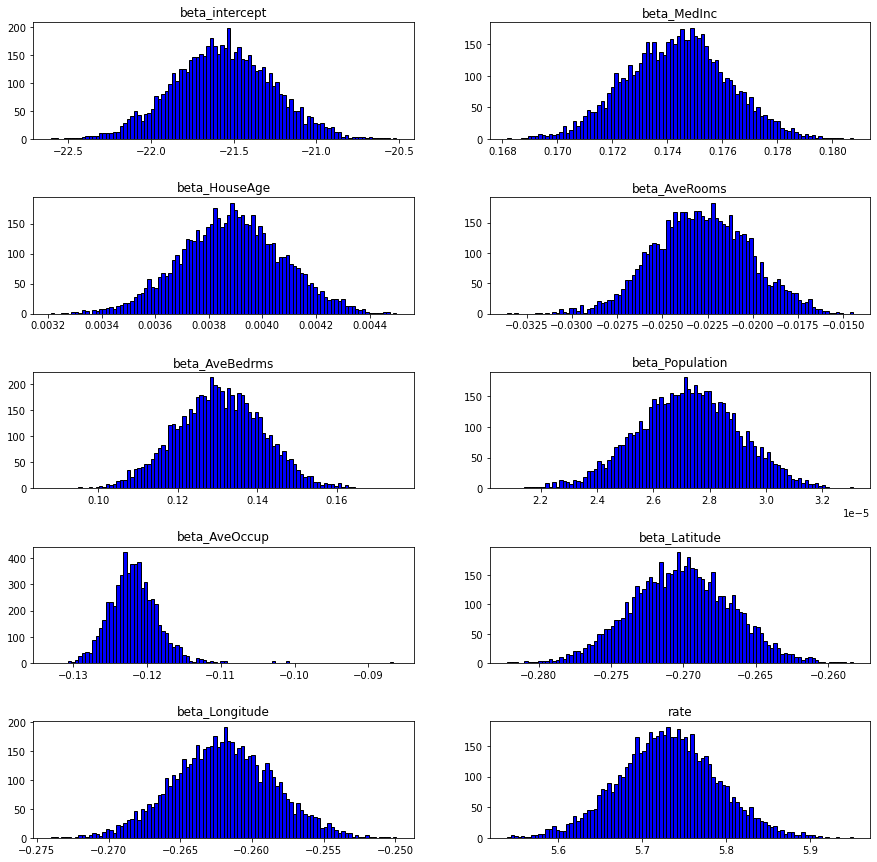

In [34]:
beta4_df = create_beta_df(my_mcmc4, my_scaler)
draw_coefficients(beta4_df)

In [35]:
coefficients = beta4_df.iloc[:, :-1].median()
display(coefficients)

linear_combination = X.dot(coefficients[1:]) + coefficients.iloc[0]
linear_combination.shape

beta_intercept    -21.570114
beta_MedInc         0.174392
beta_HouseAge       0.003886
beta_AveRooms      -0.022863
beta_AveBedrms      0.130397
beta_Population     0.000027
beta_AveOccup      -0.121950
beta_Latitude      -0.270184
beta_Longitude     -0.262017
dtype: float32

(20640,)

In [36]:
y_pred = np.exp(linear_combination)
y_pred_small = y_pred[y<5.0]
y_pred= np.where(y_pred > 5.0, 5.0, y_pred)

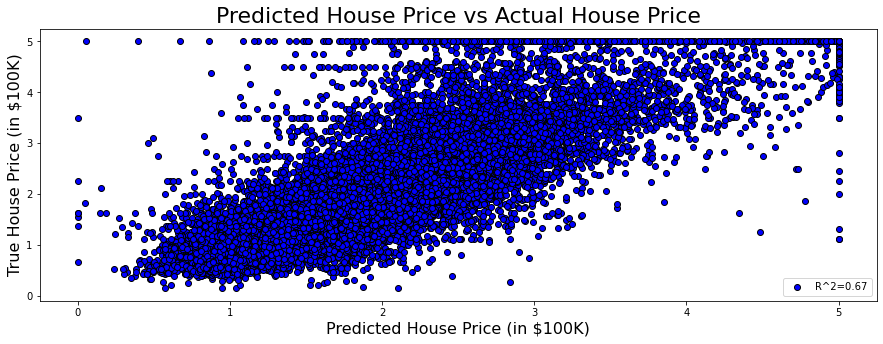

In [37]:
plt.figure(figsize=(15, 5))
plt.scatter(y_pred, y, c="blue", edgecolor="black", label=f'R^2={round(r2_score(y, y_pred), 2)}')
plt.title("Predicted House Price vs Actual House Price", size=22)
plt.xlabel("Predicted House Price (in $100K)", size=16)
plt.ylabel("True House Price (in $100K)", size=16)
plt.legend()
plt.show()

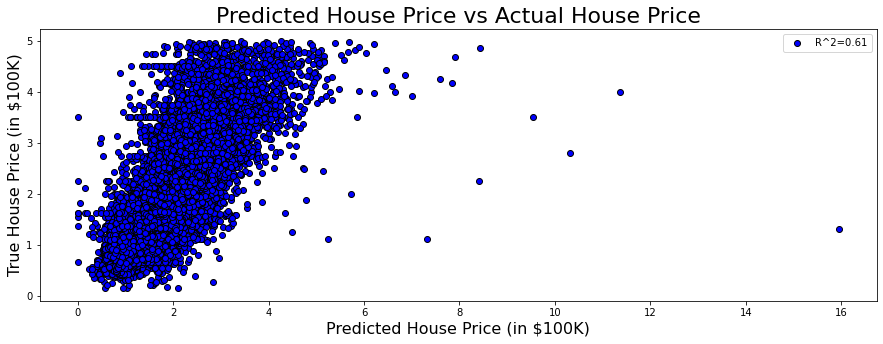

In [38]:
plt.figure(figsize=(15, 5))
plt.scatter(y_pred_small, y_small, c="blue", edgecolor="black", label=f'R^2={round(r2_score(y_small, y_pred_small),2)}')
plt.title("Predicted House Price vs Actual House Price", size=22)
plt.xlabel("Predicted House Price (in $100K)", size=16)
plt.ylabel("True House Price (in $100K)", size=16)
plt.legend()
plt.show()

In [67]:
def draw_multiple_dfs(dfs, df_labels):
    figure, axis = plt.subplots(5,2, figsize=(15,15))

    beta_df = dfs[0]
    i = 0
    for key, ax in zip(beta_df.columns, axis.ravel()):
        ax.set_title(key)
        i=0
        for df in dfs:
            ax.hist(df[key], alpha=0.5, bins=100, label=df_labels[i])            
            i+=1
        ax.legend()

    plt.subplots_adjust(hspace=0.5)

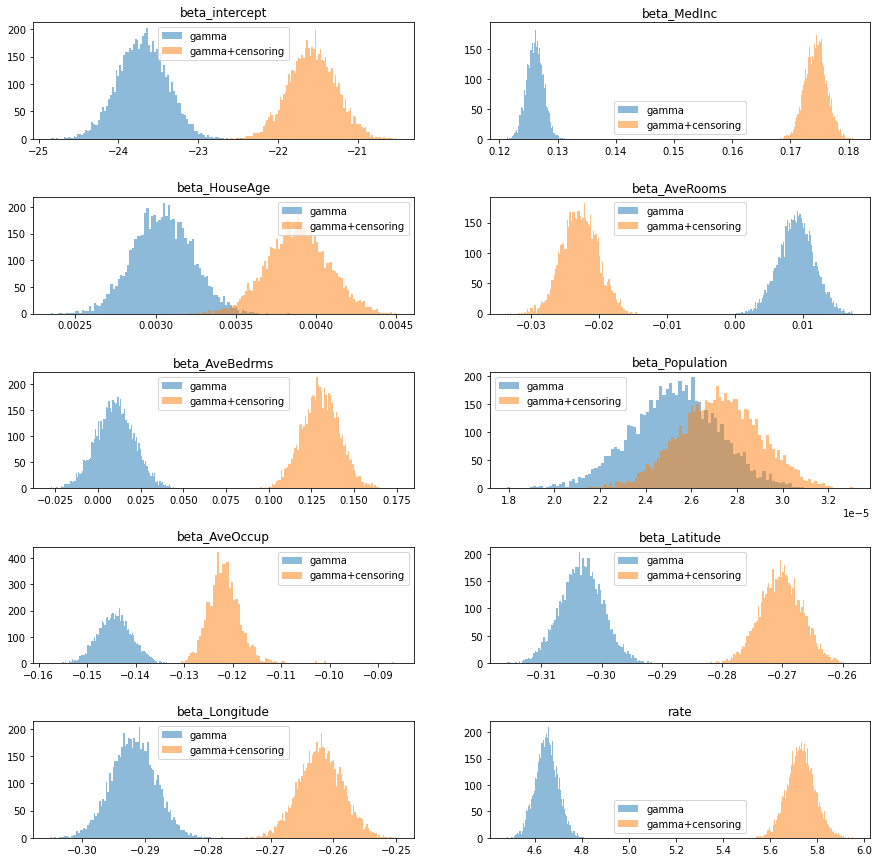

In [68]:
draw_multiple_dfs([beta3_df, beta4_df], ["gamma", "gamma+censoring"])

## SVI

In [69]:
from scipy.stats import gamma as scipygamma
def model_gamma_cen(X, y, column_names, censored_label):
    
    
    linear_combination = pyro.sample(f"beta_intercept", dist.Normal(0.0, 1.0))
    
    
    for i in range(0, X.shape[1]):
        beta_i = pyro.sample(f"beta_{column_names[i]}", dist.Normal(0.0, 1.0))
        linear_combination = linear_combination + (beta_i * X[:, i])
    
    rate = pyro.sample("rate", dist.HalfCauchy(scale=10.0))
    

    mean = torch.exp(linear_combination)
    
    shape = mean * rate
    
    
    
    
    with pyro.plate("data", y.shape[0]):
        
        outcome_dist = dist.Gamma(shape, rate)
        
        with pyro.poutine.mask(mask = (censored_label == 0.0)):
            observation = pyro.sample("obs", outcome_dist, obs=y)
            
        with pyro.poutine.mask(mask = (censored_label == 1.0)):

            truncation_prob = torch.tensor(1 - scipygamma(shape.detach(), rate.detach()).cdf(y))
            
            censored_observation = pyro.sample("censorship",
                                               dist.Bernoulli(truncation_prob),
                                               obs=torch.tensor(1.0))
        

In [164]:
from torch.distributions import constraints
def guide_gamma_cen(X, y, column_names, censored_label):
    
    mu_intercept = pyro.param("mu_intercept", torch.tensor(0.0))
    sigma_intercept = pyro.param("sigma_intercept", torch.tensor(1.0), constraint=constraints.positive)
    linear_combination = pyro.sample(f"beta_intercept", dist.Normal(mu_intercept, 
                                                                    sigma_intercept))
    
    
    for i in range(0, X.shape[1]):
        mu_beta = pyro.param(f"mu_{column_names[i]}", torch.tensor(0.0))
        sigma_beta = pyro.param(f"sigma_{column_names[i]}", torch.tensor(1.0), constraint=constraints.positive)
        beta_i = pyro.sample(f"beta_{column_names[i]}", dist.Normal(mu_beta, 
                                                                    sigma_beta))
    
    mu_rate = pyro.param("mu_rate", torch.tensor(10.0), constraint=constraints.positive)
    sigma_rate = pyro.param("sigma_rate", torch.tensor(1.0), constraint=constraints.positive)
    
    
    rate = pyro.sample("rate", dist.Gamma(mu_rate, sigma_rate))
    
        

In [ ]:
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import ClippedAdam
from pyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal

pyro.clear_param_store()
my_guide = guide_gamma_cen
#my_guide = AutoMultivariateNormal(model_gamma_cen)

my_svi = SVI(model=model_gamma_cen,
             guide= my_guide,
             optim=ClippedAdam({"lr": 0.01}),
             loss=Trace_ELBO())

X_torch = torch.tensor(X_scaled)
y_torch = torch.tensor(y)

numpy_censored_label = np.where(y >= 5.0, 1.0, 0.0)
censored_label = torch.tensor(numpy_censored_label)


for i in range(10000):
    loss = my_svi.step(X_torch,y_torch, california.feature_names, censored_label)
    normalized_loss = loss/X_torch.shape[0]
    if (i % 500 == 0):
        print(f'iter: {i}, normalized loss:{round(normalized_loss,2)}')


iter: 0, normalized loss:1.9383227481655994e+53


/anaconda3/envs/pyroenv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:873: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))
/anaconda3/envs/pyroenv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/anaconda3/envs/pyroenv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/anaconda3/envs/pyroenv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0
/anaconda3/envs/pyroenv/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


iter: 500, normalized loss:nan
iter: 1000, normalized loss:nan
iter: 1500, normalized loss:nan


In [149]:
from pyro.infer import Predictive

sample_num = 6000
predictive = Predictive(model=model_gamma_cen,
                        guide= my_guide,
                        num_samples=sample_num) # Notice this is a tuple

samples = predictive(X_torch,y_torch, california.feature_names, censored_label)


beta_svi_df = {}
for key, values in samples.items():
    if ("beta_" in key) or ("rate" in key):
        
        
        beta_svi_df[key] = values.detach().numpy().reshape(-1,)
        #print(f'finished {key}', end='\r')
        
beta_svi_df = pd.DataFrame(beta_svi_df)

In [150]:
i = 0
for col in beta_svi_df:
    if (col != 'beta_intercept'):
        if ('beta_' in col):

            beta_svi_df['beta_intercept'] -= (beta_svi_df[col] * my_scaler.mean_[i])/my_scaler.scale_[i]
            beta_svi_df[col] /= my_scaler.scale_[i]

            i += 1

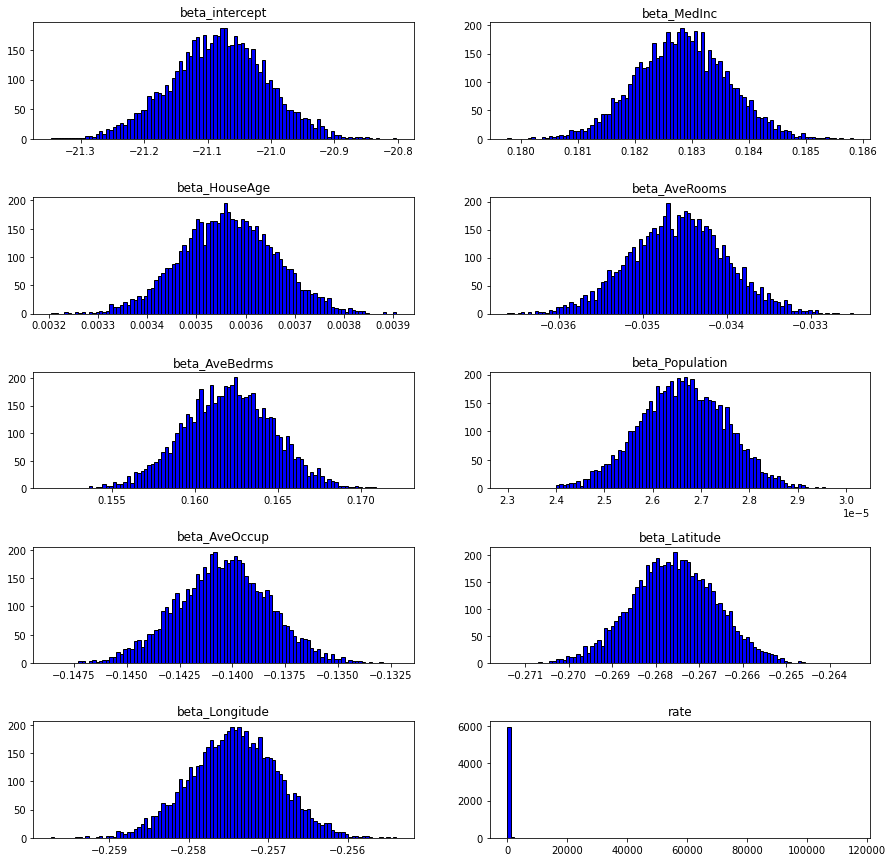

In [151]:
draw_coefficients(beta_svi_df)

In [152]:
coefficients = beta_svi_df.iloc[:, :-1].median()
display(coefficients)

linear_combination = X.dot(coefficients[1:]) + coefficients.iloc[0]
linear_combination.shape

beta_intercept    -21.081375
beta_MedInc         0.182819
beta_HouseAge       0.003563
beta_AveRooms      -0.034575
beta_AveBedrms      0.162045
beta_Population     0.000027
beta_AveOccup      -0.140417
beta_Latitude      -0.267590
beta_Longitude     -0.257428
dtype: float32

(20640,)

In [153]:
y_pred = np.exp(linear_combination)
y_pred_small = y_pred[y<5.0]
y_pred= np.where(y_pred > 5.0, 5.0, y_pred)

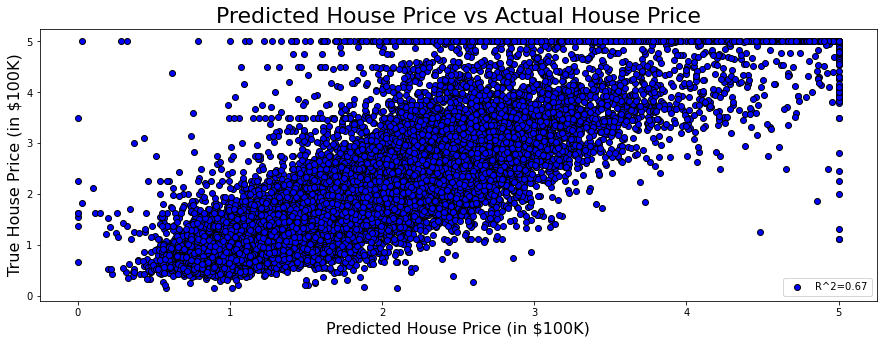

In [154]:
plt.figure(figsize=(15, 5))
plt.scatter(y_pred, y, c="blue", edgecolor="black", label=f'R^2={round(r2_score(y, y_pred), 2)}')
plt.title("Predicted House Price vs Actual House Price", size=22)
plt.xlabel("Predicted House Price (in $100K)", size=16)
plt.ylabel("True House Price (in $100K)", size=16)
plt.legend()
plt.show()

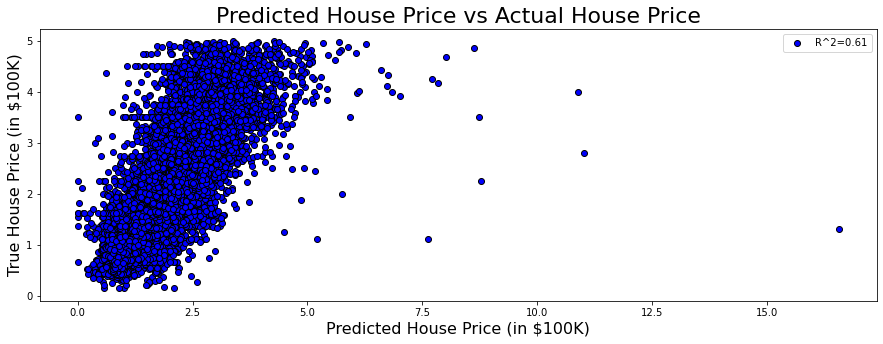

In [155]:
plt.figure(figsize=(15, 5))
plt.scatter(y_pred_small, y_small, c="blue", edgecolor="black", label=f'R^2={round(r2_score(y_small, y_pred_small),2)}')
plt.title("Predicted House Price vs Actual House Price", size=22)
plt.xlabel("Predicted House Price (in $100K)", size=16)
plt.ylabel("True House Price (in $100K)", size=16)
plt.legend()
plt.show()